###  NLP Final Project Thomas Guardi

__Notebook 3__

1. KTrain biGRU Classification Model V2 on a data set with strictly population labels

2. Targeted Sentiment Model TFIDF

3. Targeted Sentiment Model BERT (KTrain)

4. Load Tax, Lori and JB and use our model from #3 to classify sentiment and our model from #1 for Relevance

5. Extract and Analyze our Target entities with RAKE and TFIDF Vectorizer


# Modeling

In [94]:
import pandas as pd
import numpy as np
import ktrain
from ktrain import text
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Load Training Data built with Snorkel
#### Load cleaned data with 1200 labeled as relevant and 20k as irrelevant
- From notebook 2

In [3]:
labeled_news = pd.read_csv('pop_labeled_news.csv',index_col=0)
labeled_news.shape

(21493, 4)

In [4]:
labeled_news.head(5)

,title_clean,text_clean,PredictedClass,Relevant
377,"['nine', 'dekalb', 'county', 'resident', 'test...",Also: DeKalb County region on track to qualify...,events,1
666,"['eye', 'illinois', 'timing', 'link’s', 'resig...",The good news: Terry Link quit his job.. The ...,events,1
833,"['graduated', 'income', 'tax', 'illinois', 'th...",Small businesses are the heart of our neighbor...,events,1
1465,"['goodbye', 'new', 'york', 'california', 'illi...","1 / 4 Goodbye, New York, California and Illino...",events,1
1649,"['sangamon', 'among', '93', 'illinois', 'count...","Sangamon saw its population decrease by 2,419,...",events,1


In [5]:
labeled_news.shape

(21493, 4)

### K Train Learner Object
- great library!

In [6]:
import ktrain
from ktrain import text

In [7]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

In [9]:
maxFeatures = 20000 #num of words to consider in vocabulary
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
nGramRange = 2 #size of multi-word phrases to consider
preprocessMode='standard' #Either 'standard' (normal tokenization) or 'bert' tokenization and preprocessing for use with BERT text classification model.
sampleSize = 0.3 #Proportion of training to use for validation

(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = labeled_news, 
                                                                    text_column  = 'text_clean', 
                                                                    label_columns = ['Relevant'],
                                                                       val_pct=sampleSize,
                                                                       preprocess_mode=preprocessMode, #text must be preprocessed in a specific way for use with BERT
                                                                       maxlen=maxLen, 
                                                                       max_features=maxFeatures)

language: en
Word Counts: 100636
Nrows: 15045
15045 train sequences
train sequence lengths:
	mean : 314
	95percentile : 841
	99percentile : 969
x_train shape: (15045,200)
y_train shape: (15045, 2)
Is Multi-Label? False
6448 test sequences
test sequence lengths:
	mean : 317
	95percentile : 842
	99percentile : 976
x_test shape: (6448,200)
y_test shape: (6448, 2)


In [10]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

#### Load BiGRU model

In [11]:
model = text.text_classifier('bigru', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
compiling word ID features...
maxlen is 200
word vectors will be loaded from: https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
processing pretrained word vectors...
loading pretrained word vectors...this may take a few moments...


done.


In [12]:
batchSize = 64

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)

#### Find a good learning rate

In [13]:
learner.lr_find(max_epochs=10)

simulating training for different learning rates... this may take a few moments...
Epoch 1/10
236/236 [==============================] - 47s 197ms/step - loss: 0.6760 - accuracy: 0.6556
Epoch 2/10
236/236 [==============================] - 45s 189ms/step - loss: 0.6495 - accuracy: 0.8023
Epoch 3/10
236/236 [==============================] - 45s 189ms/step - loss: 0.5236 - accuracy: 0.9266
Epoch 4/10
236/236 [==============================] - 45s 189ms/step - loss: 0.2988 - accuracy: 0.9299
Epoch 5/10
236/236 [==============================] - 44s 187ms/step - loss: 0.1820 - accuracy: 0.9422
Epoch 6/10
236/236 [==============================] - 44s 187ms/step - loss: 0.0706 - accuracy: 0.9803
Epoch 7/10
236/236 [==============================] - 44s 187ms/step - loss: 0.0823 - accuracy: 0.9764
Epoch 8/10
236/236 [==============================] - 53s 223ms/step - loss: 0.3747 - accuracy: 0.9202


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help 

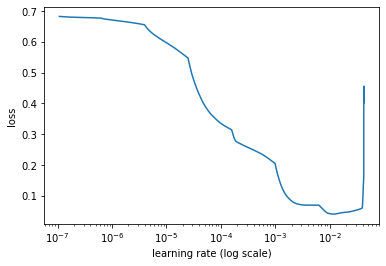

In [14]:
learner.lr_plot()

In [15]:
learningRate = 0.001
numEpoch = 3
learner.autofit(learningRate, numEpoch)



begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/3
236/236 [==============================] - 51s 215ms/step - loss: 0.2016 - accuracy: 0.9445 - val_loss: 0.0776 - val_accuracy: 0.9781
Epoch 2/3
236/236 [==============================] - 49s 208ms/step - loss: 0.0593 - accuracy: 0.9831 - val_loss: 0.0694 - val_accuracy: 0.9809
Epoch 3/3
236/236 [==============================] - 54s 227ms/step - loss: 0.0339 - accuracy: 0.9900 - val_loss: 0.0738 - val_accuracy: 0.9822


### Evaluate
- Great results

In [16]:
learner.validate(val_data=(x_test, y_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6010
           1       0.94      0.79      0.86       438

    accuracy                           0.98      6448
   macro avg       0.96      0.89      0.92      6448
weighted avg       0.98      0.98      0.98      6448



array([[5989,   21],
       [  94,  344]])

### Make Predictions

In [17]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [30]:
labeled_news.shape

(21493, 4)

In [31]:
# NumRecs = 1000

target = labeled_news.Relevant.iloc[0:]
predicted = predictor.predict(labeled_news.text_clean.iloc[0:].tolist())
data = labeled_news.text_clean.iloc[0:]



In [32]:
results = pd.DataFrame(list(zip(target, predicted, data)), 
               columns =['target', 'predicted', 'data']) 

In [40]:
results.sample(5)

,target,predicted,data
7655,0,not_Relevant,Lipinski could make station issue part of Amtrak reauthorization bill The full text of this article is available to Trains Magazine subscribers on...
1341,1,Relevant,"Former House candidate Mike Babcock, a Republican, dreams of the day when Springfield is more about service and less about politics.. “I think we..."
18168,0,not_Relevant,Vulture Joe Biden no Atticus Finch. Protests have continued for weeks to call for police reform after emergency medical technician Breonna Taylor...
5042,0,not_Relevant,"Aaron Sorkin's new Netflix movie 'The Trial of the Chicago 7' arrives on our screens in October. In the present climate, it's going to be a timely..."
13913,0,not_Relevant,Ask me anything! Anonymous asked:. apparently its not manadatory to wear a helmet in Illinois but it is in cali. so thats why he doesnt wear one ...


In [51]:
results.iloc[482]

target                                                                                                                                                           1
predicted                                                                                                                                                 Relevant
data         New York and Illinois saw sharp population drops during 2019 as "natural" population growth across the country reached its lowest level in decades...
Name: 482, dtype: object

In [52]:
results.predicted.value_counts()

not_Relevant    20123
Relevant         1370
Name: predicted, dtype: int64

In [41]:
results.to_csv('results_pop_clf.csv')

In [20]:
pd.set_option('max_colwidth', 150)


### Save and Reload

In [36]:
# predictor.save('my_predictor_pop')

In [37]:
# reloaded_predictor_clf = ktrain.load_predictor('my_predictor_pop')

In [56]:
print(reloaded_predictor.predict(labeled_news.text_clean.iloc[0]))

Relevant


In [43]:
# sample 100 where target was 1 and
#  = results[results['target'] == 1].sample(100,random_state=42)
relevant_res = results[(results['target'] == 1) & (results['predicted'] == 'Relevant')].sample(100,random_state=42)
relevant_res.sample(5)

,target,predicted,data
1424,1,Relevant,"Grace Hauck USA TODAY CHICAGO — Midwestern cities are leading the nation in providing opportunities to immigrant communities, and Chicago's settin..."
401,1,Relevant,"There were 38,863 businesses in Illinois that had between 10 and 19 employees in 2016, according to County Business Patterns (CBP) statistics prov..."
710,1,Relevant,It was a close competition between Indiana and Florida: Which state in 2018 attracted the most Illinois residents for relocation?. Indiana won. N...
265,1,Relevant,"Arts, Entertainment and Recreation Wages and Salaries in Illinois (ILWART) Download Q2 2020: 2,261,949 Notes: Industry based on North American Ind..."
1486,1,Relevant,"As early as 2012, Francis Menton, aka the Manhattan Contrarian, wrote about Chicago, referring to it as a “basket case,” due to: declining populat..."


## Analyse Population Relevant Articles

In [45]:
rel_pop = results[results['predicted'] == 'Relevant'] 

In [50]:
#### 1370 relevant articles

In [54]:
rel_pop.head(1)

,target,predicted,data
0,1,Relevant,Also: DeKalb County region on track to qualify for Phase 3 re-opening pending testing metrics By Daily Chronicle Mark Black for Shaw Media Caption...


In [49]:
rel_pop.predicted.value_counts()

Relevant    1370
Name: predicted, dtype: int64

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words='english',ngram_range=(3,3))
tvec_weights = tvec.fit_transform(rel_pop.data)
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
# weights_df.sort_values(by='weight', ascending=False).head(50)

In [74]:
weights_df.sort_values(by='weight', ascending=False).head(10)

,term,weight
1229,average list price,0.010707
9785,single family homes,0.010081
2862,covid 19 pandemic,0.008635
2081,chicago mayor lori,0.008388
10930,united states census,0.008305
10255,stay home order,0.007851
8249,president donald trump,0.007175
10180,states census bureau,0.006779
2981,data census bureau,0.006448
1780,cbp statistics provided,0.006024


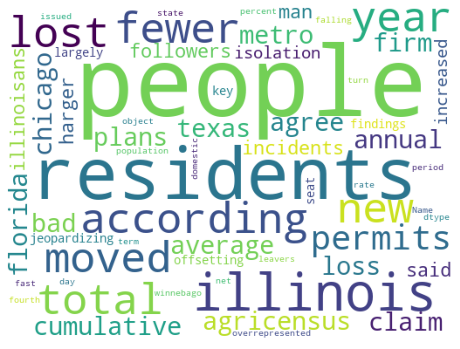

In [75]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
plt.subplots(figsize = (8,8))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(str(weights_df['term'][:50]))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
# plt.savefig('Plotly-World_Cloud.png')
plt.show()

In [ ]:
import plotly.express as px
fig = px.histogram(jb, x='predicted',title='Targeted Sentiment',color='label')
fig.show()

# Targeted Sentiment

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

### Curated Sentiment Labels

In [8]:
df = pd.read_csv('pop_sent.csv',index_col=0)
df.shape

(1493, 4)

In [9]:
df.head(5)

,Title,Text,PredictedClass,TopScore
0,"['nine', 'dekalb', 'county', 'resident', 'test...",Also: DeKalb County region on track to qualify...,positive,0.507086
1,"['eye', 'illinois', 'timing', 'link’s', 'resig...",The good news: Terry Link quit his job.. The ...,negative,0.529905
2,"['graduated', 'income', 'tax', 'illinois', 'th...",Small businesses are the heart of our neighbor...,negative,0.601610
3,"['goodbye', 'new', 'york', 'california', 'illi...","1 / 4 Goodbye, New York, California and Illino...",negative,0.502320
4,"['sangamon', 'among', '93', 'illinois', 'count...","Sangamon saw its population decrease by 2,419,...",negative,0.700347


### TrainTest Split

In [10]:
X = df['Text']
y = df['PredictedClass']

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

In [110]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

In [111]:
X.shape,y.shape

((1493,), (1493,))

In [112]:
# 1 = Positive
# 0 = Negative
y

array([1, 0, 0, ..., 0, 0, 1])

## Vectorize

In [113]:
vect = TfidfVectorizer(stop_words='english', ngram_range=(2,4))

# fit and transform
X_train_vec = vect.fit_transform(X_train)
X_test_vec = vect.transform(X_test)


In [114]:
X_train_vec

<1000x476203 sparse matrix of type '<class 'numpy.float64'>'
	with 702611 stored elements in Compressed Sparse Row format>

### MB Bayes - Very overfit

In [66]:
# Multinomial Naive Bayes model
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
t_pred_class = mnb.predict(X_train_vec)
y_pred_class = mnb.predict(X_test_vec)

print(classification_report(t_pred_class, y_train))
print(classification_report(y_pred_class, y_test))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       751
           1       0.80      0.99      0.89       249

    accuracy                           0.94      1000
   macro avg       0.90      0.96      0.92      1000
weighted avg       0.95      0.94      0.94      1000

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       455
           1       0.17      0.61      0.27        38

    accuracy                           0.74       493
   macro avg       0.56      0.68      0.55       493
weighted avg       0.90      0.74      0.80       493



In [70]:
# Get Features
feature_names = vect.get_feature_names()
coefs_with_fns = zip(feature_names,mnb.coef_[0])

coefs_with_fns_df = pd.DataFrame(coefs_with_fns,
                             columns=['feature','coefficient'])

In [73]:
coefs_with_fns_df.sort_values(by='coefficient',ascending=False,inplace=True)
coefs_with_fns_df.head(50)

,feature,coefficient
156106,employees illinois,-11.903035
120415,covid 19,-11.947981
79470,census bureau,-11.958092
22994,500 employees,-12.108305
11476,2012 2016,-12.160219
447753,united states,-12.244187
22997,500 employees illinois,-12.278394
99390,collected illinois,-12.296030
355435,real estate,-12.298190
428179,tax collections,-12.317109


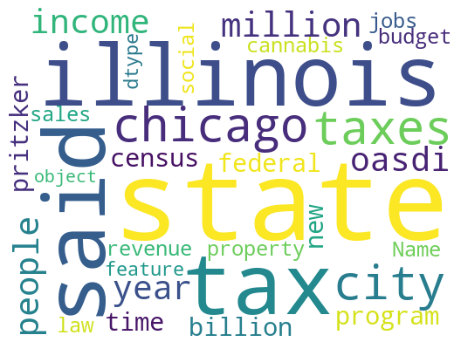

In [22]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
plt.subplots(figsize = (8,8))

wordcloud = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(str(coefs_with_fns_df['feature'][:30]))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
# plt.savefig('Plotly-World_Cloud.png')
plt.show()

In [120]:
from sklearn.ensemble import RandomForestClassifier
# Random Forest
rf = RandomForestClassifier(max_depth = 2)
rf.fit(X_train_vec, y_train)
t_pred_class = rf.predict(X_train_vec)
y_pred_class = rf.predict(X_test_vec)

print(classification_report(t_pred_class, y_train))
print(classification_report(y_pred_class, y_test))

              precision    recall  f1-score   support

           0       1.00      0.70      0.82       993
           1       0.02      1.00      0.04         7

    accuracy                           0.70      1000
   macro avg       0.51      0.85      0.43      1000
weighted avg       0.99      0.70      0.82      1000

              precision    recall  f1-score   support

           0       1.00      0.73      0.84       492
           1       0.01      1.00      0.01         1

    accuracy                           0.73       493
   macro avg       0.50      0.86      0.43       493
weighted avg       1.00      0.73      0.84       493



# Train Sentiment Classifier for use on Targeted Entities

- Using KTrain

In [12]:
df = pd.read_csv('pop_sent.csv',index_col=0)
df.shape

(1493, 4)

In [81]:
df.head(1)

,Title,Text,PredictedClass,TopScore
0,"['nine', 'dekalb', 'county', 'resident', 'test...",Also: DeKalb County region on track to qualify...,positive,0.507086


In [14]:
import ktrain
from ktrain import text

### Load Data, Split and Process for BERT

In [87]:
maxLen = 200 #each document can be of most <maxLen> words. 0 is used as padding ID.
nGramRange = 1 #size of multi-word phrases to consider
preprocessMode='bert' 
sampleSize = 0.3 #Proportion of training to use for validation

(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_df(train_df = df,
                                                                    text_column = 'Text',
                                                                    label_columns = 'PredictedClass',
                                                                    val_pct=sampleSize,
                                                                    preprocess_mode=preprocessMode, 
                                                                    maxlen=maxLen)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


### Pre-Trained BERT

In [88]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

batchSize = 16

learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=batchSize)

Is Multi-Label? False
maxlen is 200
done.


### Train

__Find the optimal learning rate__

In [89]:
# briefly simulate training to find good learning rate

learner.lr_find(max_epochs=3)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
66/66 [==============================] - 334s 5s/step - loss: 0.6116 - accuracy: 0.6995
Epoch 2/3
66/66 [==============================] - 328s 5s/step - loss: 0.7846 - accuracy: 0.6641
Epoch 3/3
66/66 [==============================] - 336s 5s/step - loss: 31.7325 - accuracy: 0.5943


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


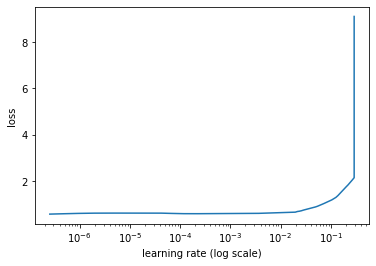

In [90]:
learner.lr_plot()

In [91]:
learningRate = 2e-5
numEpoch = 1

# learner.fit_onecycle(learningRate, numEpoch)
learner.autofit(learningRate, numEpoch)



begin training using triangular learning rate policy with max lr of 2e-05...
66/66 [==============================] - 399s 6s/step - loss: 0.5823 - accuracy: 0.7225 - val_loss: 0.5569 - val_accuracy: 0.7143


### Validate

In [92]:
learner.validate(val_data=(x_test, y_test))

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       317
           1       0.53      0.21      0.30       131

    accuracy                           0.71       448
   macro avg       0.63      0.57      0.56       448
weighted avg       0.68      0.71      0.67       448



array([[293,  24],
       [104,  27]])

### Predictions

In [94]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [95]:
predictor.get_classes()

['negative', 'positive']

In [97]:
print(predictor.predict(X_train[0]))

negative


In [103]:
NumRecs = 1000

target = df.PredictedClass.iloc[0:NumRecs]
predicted = predictor.predict(df.Text.iloc[0:NumRecs].tolist())
data = df.Text.iloc[0:NumRecs]


results = pd.DataFrame(list(zip(target, predicted, data)), 
               columns =['target', 'predicted', 'data']) 

In [104]:
pd.set_option('max_colwidth', 100)

results.head(10)

,target,predicted,data
0,positive,negative,Also: DeKalb County region on track to qualify for Phase 3 re-opening pending testing metrics By...
1,negative,negative,The good news: Terry Link quit his job.. The bad news: Not fast enough.. Let’s review: On Aug....
2,negative,negative,Small businesses are the heart of our neighborhoods. Jobs that are created by small businesses a...
3,negative,negative,"1 / 4 Goodbye, New York, California and Illinois. Hello … Where? (Bloomberg Opinion) -- New York..."
4,negative,negative,"Sangamon saw its population decrease by 2,419, or 1.2 percent, over the last decade, according t..."
5,negative,negative,"Sangamon saw its population decrease by 2,419, or 1.2 percent, over the last decade, according t..."
6,negative,negative,Remodeling how Illinois’ political districts are drawn is the key to addressing the “dark cloud”...
7,negative,negative,Home price growth stalled last fall in the Chicago area.. The region’s single-family home value...
8,positive,negative,By Shirin Ali Medill Reports Thousands of people gathered in Grant Park on Saturday to march for...
9,negative,negative,"Illinois collected $5.4 billion in individual income taxes during the 2nd quarter of 2019, accor..."


In [116]:
# predictor.save('my_predictor_target_sent')

In [55]:
# reload the predictor

reloaded_predictor_sent = ktrain.load_predictor('my_predictor_target_sent')

In [118]:
# make a prediction on the same document to verify it still works

reloaded_predictor.predict(X_train[0])

'negative'

# Use Predictor on Lightfoot and Pritzker and Tax Articles

### Get the overall sentiment on our characters

In [30]:
df = pd.read_csv('tax_lori_jb.csv')
df.shape

(28841, 5)

In [31]:
df.head(5)

,Unnamed: 0,title_clean,text_clean,PredictedClass,label
0,9,"['southern', 'illinois', 'county', 'deal', 'fu...",Southern Illinois counties deal with funding s...,events,0
1,10,"['bankruptcy', 'auction', 'chilicoti', 'illino...",scarus compressus bankruptcy epfo member porta...,events,0
2,11,"['illinois', 'receives', '1st', 'allotment', '...",In this March 2020 photo provided by Gilead Sc...,health,2
3,12,"['pritzker', 'illinois', '‘going', 'alone’', '...","Another 1,656 people in Illinois have tested p...",politics,2
4,22,"['att', 'provides', 'meal', '6000', 'chicago',...","AT&T provides meals to 6,000 Chicago Police of...",business,1


## Make Predictions with BERT Predictor

In [184]:
# Test Run = 450 Negative and 50 positive, Lori and Taxes get it the worst, JB the least
# NumRecs = 500
# predicted = predictor.predict(df.text_clean.iloc[0:NumRecs].tolist())
# data = df.text_clean.iloc[0:NumRecs]

predicted = predictor.predict(df.text_clean.iloc[0:].tolist())
data = df.text_clean.iloc[0:]

In [186]:
results = pd.DataFrame(list(zip(predicted, data)), 
               columns =['predicted', 'data']) 

In [28]:
results = pd.read_csv('results_sentiment.csv',index_col=0)
results.sample(6)

,predicted,data
1796,negative,Chicago Mayor Lori Lightfoot on Wednesday even...
11206,negative,As officials work to increase access to COVID-...
27531,positive,Illinois Board of Higher Education Awards $1.3...
26607,negative,"Filed Under: Coronavirus , COVID-19 , Illinois..."
1328,positive,Save. (The Center Square) – The first report ...
21745,negative,Jonathan A. “Yoni” Pizer is endorsed by the Su...


## Build DataFrame of Sentiment and Tax, Lori, or JB labels

- Tax = 0
- Lori = 1
- JB = 2

In [32]:
labels = pd.Series(df['label'])
titles = pd.Series(df['title_clean'])
results['title'] = titles
results['label'] = labels

In [33]:
pd.set_option('display.max_colwidth', 150)

In [34]:
results.sample(5)

,predicted,data,title,label
14787,positive,"CHICAGO , April 1, 2020 /PRNewswire/ --. WHO: Gov. JB Pritzker, Illinois Department of Public Health Director Dr. Ngozi Ezike , AARP State Direct...","['gov', 'jb', 'pritzker', 'public', 'health', 'chief', 'dr', 'ngozi', 'ezike', 'address', 'concern', 'older', 'adult', 'aarp', 'illinois', 'covid1...",2
2594,negative,"The coronavirus crisis sparked a rare bipartisan push from the delegation. Mar 24, 2020, 8:22pm CDT Share this story The Illinois National Guard o...","['illinois', 'congressional', 'delegation', 'asks', 'defense', 'department', 'help', 'national', 'guard', 'cost']",2
13739,negative,"If Kelly’s lawsuit is successful, injured business owners and individuals who have lost their jobs or income due to Mayor Lightfoot and Gov. Pritz...","['illinois', 'leak', 'kelly', 'v', 'lightfoot', 'pritzker', 'lawsuit', 'open', 'door', 'million', 'covid19', 'damage', 'business', 'employee', 'go...",2
8703,negative,"Chicago chief's firing again rattles confidence in force by Don Babwin, Posted Dec 7, 2019 8:58 am MST FILE - In this Thursday, Nov. 7, 2019, file...","['chicago', 'chief’s', 'firing', 'rattle', 'confidence', 'force']",1
19322,negative,"SYCAMORE - Two more have tested positive for the coronavirus in DeKalb County, bringing the total up to eight as of Sunday afternoon, according to...","['2', 'test', 'positive', 'covid19', 'dekalb', 'county', 'say', 'illinois', 'department', 'public', 'health']",2


In [207]:
results.predicted.value_counts()

not_Relevant    20123
Relevant         1370
Name: predicted, dtype: int64

#### Save Dataframe

In [35]:
# results.to_csv('results_sentiment.csv')

In [38]:
#### Not very popular topics

In [37]:
import plotly.express as px
fig = px.histogram(results, x='predicted',title='Target Sentiment for Taxes, Lori, JB')
fig.show()

## Investigate

#### Lori Lightfoot

In [47]:
lori = results[results['label'] == 2]
jb = results[results['label'] == 1]
tax = results[results['label'] == 0]

In [203]:
print(lori.predicted.value_counts())
print(jb.predicted.value_counts())
print(tax.predicted.value_counts())

negative    3007
positive     272
Name: predicted, dtype: int64
negative    244
positive     59
Name: predicted, dtype: int64
negative    4475
positive     976
Name: predicted, dtype: int64


# KPI Calculations

In [208]:
3007 + 244 + 4475

7726

In [209]:
272 + 59 + 976

1307

In [210]:
1307 / 7726

0.16916903960652344

In [204]:
272/3007

0.09045560359161955

In [205]:
59/244

0.24180327868852458

In [206]:
976/4475

0.21810055865921787

In [54]:
import plotly.express as px
fig = px.histogram(results, x='predicted',title='Sentiment: Tax=Blue, JB=Green, Lori=Red',color='label')
fig.show()

In [178]:
import plotly.express as px
fig = px.histogram(jb, x='predicted',title='Targeted Sentiment',color='label')
fig.show()

# Apply Predictor 
 __From Notebook 2 - biGru classifier__
 
### Apply to our sentiment articles to find the most relevant for further analysis

In [4]:
# load data
results = pd.read_csv('results_sentiment.csv',index_col=0)

In [5]:
#load predictor
reloaded_predictor_clf = ktrain.load_predictor('my_predictor')

### Relevance Predictions on Tax, JB and Lori Sentiment

In [6]:
predicted_clf = reloaded_predictor_clf.predict(results.data.iloc[0:].tolist())
data_clf = results.data.iloc[0:]

In [7]:
results['predicted_clf'] = predicted_clf

In [9]:
results['predicted_clf'].value_counts()

not_Relevant    19808
Relevant         9033
Name: predicted_clf, dtype: int64

In [10]:
rel_results = results[results['predicted_clf'] == 'Relevant']

In [11]:
rel_results.head(1)

,predicted,data,title,label,predicted_clf
0,negative,Southern Illinois counties deal with funding s...,"['southern', 'illinois', 'county', 'deal', 'fu...",0,Relevant


In [12]:
# rel_results.to_csv('rel_results.csv')

# RAKE keyword extraction

In [79]:
rel_results = pd.read_csv('rel_results.csv',index_col=0)

In [80]:
rel_results.shape

(9033, 5)

In [82]:
rel_results.sample(5)

,predicted,data,title,label,predicted_clf
5449,negative,Fox News Flash top headlines for Jan. 9. Fox News Flash top headlines for Jan. 9 are here. Check out what’s clicking on Foxnews.com. An Illinois...,"['very', 'drunk', 'man', 'arrested', 'illinois', 'airport', 'locking', 'bathroom', 'drink', 'smoke']",0,Relevant
18504,negative,"With the closing of the holiday season, a new season begins — tax time. As you review your financials and consider personal donations before filin...","['commentary', 'consider', 'empower', 'illinois', 'state', 'tax', 'credit', 'contribution']",0,Relevant
9963,positive,"Burnham Park Plaza is a 25-story luxury residential condominium building located at 40 E 9th Street in the Loop neighborhood of Chicago, Illinois....","['burnham', 'park', 'plaza', 'loop', 'chicago', 'illinois', 'january', '2020']",0,Relevant
14582,negative,"Sworn statements and lien waivers. Union and office payroll function. Quarterly payroll tax returns. General ledger maintenance, journal entrie...","['usailchicago', 'sr', 'accountant']",0,Relevant
20674,positive,Category: Blog Sign up for the e-newsletter Breaking News Learn about breaking news as it transpires. We Keep to the stories and update you as the...,"['polish', 'american', 'chicago']",0,Relevant


In [83]:
lori = rel_results[rel_results['label'] == 2]
jb = rel_results[rel_results['label'] == 1]
tax = rel_results[rel_results['label'] == 0]

In [118]:
tax_pos = tax[tax['predicted'] == 'positive']
tax_neg = tax[tax['predicted'] == 'negative']

lori_pos = lori[lori['predicted'] == 'positive']
lori_neg = lori[lori['predicted'] == 'negative']

jb_pos = jb[jb['predicted'] == 'positive']
jb_neg = jb[jb['predicted'] == 'negative']

### Apply keyword phrases from Rake

In [119]:
from rake_nltk import Rake

r = Rake()
def rake_implement(x,r):
    r.extract_keywords_from_text(x)
    return r.get_ranked_phrases()

tax_pos['rake_phrases'] = tax_pos['data'].apply(lambda x: rake_implement(x,r))
tax_neg['rake_phrases'] = tax_neg['data'].apply(lambda x: rake_implement(x,r))
lori_pos['rake_phrases'] = lori_pos['data'].apply(lambda x: rake_implement(x,r))
lori_neg['rake_phrases'] = lori_neg['data'].apply(lambda x: rake_implement(x,r))
jb_pos['rake_phrases'] = jb_pos['data'].apply(lambda x: rake_implement(x,r))
jb_neg['rake_phrases'] = jb_neg['data'].apply(lambda x: rake_implement(x,r))


In [198]:
tax_pos.sample(3)

,predicted,data,title,label,predicted_clf,rake_phrases
3878,positive,The Chicago Park District has proposed a modest tax increase for homeowners but is keeping program fees the same in its proposed $487 million budg...,"['chicago', 'park', 'district', 'proposes', 'property', 'tax', 'increase', '2020', 'won’t', 'raise', 'fee', 'day', 'camp', 'summer', 'camp']",0,Relevant,"[parks ,” superintendent michael kelly said .., chief financial officer steve lux said families, busiest lots like north avenue beach, chicago cop..."
16128,positive,"$20.00 to $22.00 Hourly Send applications or inquiries to: For your privacy and security , when applying for a job, never provide your social secu...","['full', 'charge', 'bookkeeper', 'thomas', 'society', 'chicago', 'il']",0,Relevant,"[daily accounting tasks • prepare daily net cash bank deposit report adjusted forpending unpaid invoices, including excellent verbal andwritten co..."
23935,positive,"Chicago suburb to use marijuana sales tax to fund local reparations program Wed, 11/27/2019 - 11:40am GENEVIEVE BOOKWALTER Pioneer Press. CHICAGO...","['chicago', 'suburb', 'use', 'marijuana', 'sale', 'tax', 'fund', 'local', 'reparation', 'program', 'iola', 'register']",0,Relevant,"[many different areas ,” said oliver ruff, local reparations program could gain traction quickly, evanston resident .. simmons ’ proposal came, st..."


In [183]:
tax_neg.sample(3)

,predicted,data,title,label,predicted_clf,rake_phrases
20870,negative,"Illinois man admits to stealing millions from investor Updated 4:31 pm CST, Wednesday, February 5, 2020. CHICAGO (AP) — A suburban Chicago man wh...","['illinois', 'man', 'admits', 'stealing', 'million', 'investor', 'edwardsville', 'intelligencer']",0,Relevant,"[las vegas sports gambling scene pleaded guilty wednesday, district judge elaine bucklo scheduled, income “ substantially exceeded, gorodetsky reg..."
9917,negative,"Chicago is a pretty big city, but it also boasts CTA (Chicago Transit Authority), the country's second largest public transit system. The CTA oper...","['top', '50', 'thing', 'chicago', 'infographic']",0,Relevant,"[html '>< img src =' https :// 1, href =' https :// www, href ="" http :// www, second largest public transit system, alt =' top 50 things, chicago..."
21007,negative,"Legalize it? Joe Biden tries to clear air on marijuana stance. This city’s plan to boost its black residents is budding.. Lawmakers in Evanston,...","['legal', 'weed', 'fund', 'africanamerican', 'reparation', 'program', 'illinois', 'town']",0,Relevant,"[damaged ,” alderman robin rue simmons said .. evanston, hot topic among democrats running, 10 million reparations program, evanston review .., le..."


## TFIDF on Keywords

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vec_weights(df_value):
    tvec = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words='english',ngram_range=(3,4))
    tvec_weights = tvec.fit_transform(df_value)
    weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
    return weights_df.sort_values(by='weight', ascending=False).head(100)    

In [185]:
vec_weights(tax_neg.title)[:40]

,term,weight
4,beneficiary illinois zip,0.026402
5,block club chicago,0.024358
42,oasdi beneficiary illinois,0.014374
63,total oasdi beneficiary illinois,0.014374
62,total oasdi beneficiary,0.014374
43,oasdi beneficiary illinois zip,0.013521
70,widow parent beneficiary,0.013443
71,widow parent beneficiary illinois,0.012618
49,oasdi widow parent beneficiary,0.012618
48,oasdi widow parent,0.012618


In [186]:
vec_weights(tax_pos.title)[:30]

,term,weight
27,block club chicago,0.037910
69,chicago pls rt,0.028824
126,il usa job chicago,0.027898
287,usa job chicago,0.027898
51,chicago il usa job,0.027891
50,chicago il usa,0.027891
162,job chicago pls rt,0.027733
161,job chicago pls,0.027733
288,usa job chicago pls,0.027733
36,central illinois evening,0.021995


In [171]:
tax_pos.iloc[113]

predicted                                                                                                                                                     positive
data             Illinois Historic Preservation Tax Credit Program Benefiting Communities / MyRadioLink.com January 22, 2020 11:09 am For Immediate Release Illinoi...
title                                                                  ['illinois', 'historic', 'preservation', 'tax', 'credit', 'program', 'benefiting', 'community']
label                                                                                                                                                                0
predicted_clf                                                                                                                                                 Relevant
rake_phrases     [new statewide historic preservation income tax credit program encouraging private investment, immediate release illinois historic preservation ta..

In [172]:
vec_weights(lori_pos.title)[:40]

,term,weight
215,block club chicago,0.010235
1121,mayor lori lightfoot,0.008984
347,chicago mayor lori,0.006524
1681,tax amnesty program,0.006384
902,illinois tax amnesty,0.005743
1521,restaurant week 2020,0.005694
1253,online reservation open,0.005694
376,chicago restaurant week,0.005694
129,amnesty program net,0.005320
1392,program net 60,0.005320


In [173]:
vec_weights(lori_neg.title)[:40]

,term,weight
1,block club chicago,0.020407
16,gov jb pritzker,0.011491
49,mayor lori lightfoot,0.011460
20,graduated income tax,0.009931
8,chicago mayor lori,0.006474
67,state regional heraldreviewcom,0.006021
58,progressive income tax,0.005989
35,illinois news brief,0.005451
21,hit illinois news,0.005451
60,quick hit illinois,0.005451


In [174]:
vec_weights(jb_pos.title)[:40]

,term,weight
236,mayor lori lightfoot,0.022908
74,chicago mayor lightfoot,0.021498
356,women march chicago,0.017758
75,chicago mayor lori,0.015961
65,chicago grant 700k,0.013433
95,city chicago grant,0.012570
227,march chicago honor,0.011982
84,chicago public library,0.011655
232,mayor lightfoot chicago,0.011497
207,lightfoot join aarp,0.010352


In [175]:
vec_weights(jb_neg.title)[:40]

,term,weight
71,arrested riding horse,0.014965
1146,riding horse chicago,0.014903
900,mayor lori lightfoot,0.014406
436,cowboy arrested riding,0.012714
292,chicago mayor lori,0.012339
677,horse chicago highway,0.012009
218,chicago announces new,0.010733
944,new effort boost,0.010733
60,announces new effort,0.010733
521,dreadhead cowboy arrested,0.010680
